In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from  tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Pre processing and Loading the train and test data.

In [4]:
train_path= r"C:\Users\shara\FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train"
test_path= r"C:\Users\shara\FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test"

### Data Agumentation and Normalization

In [5]:
train_generator= ImageDataGenerator(rescale=1./255,
    height_shift_range=0.2,
    width_shift_range=0.2, 
    rotation_range=30,
    zoom_range=0.2,  
    shear_range=0.2,  
    horizontal_flip=True,   
    fill_mode='nearest')
test_generator= ImageDataGenerator(rescale=1./255, horizontal_flip= True)

### Loading Data.

In [6]:
#Fixing the Image size and Batch Size
ImageSize=(224,224)
BatchSize=32

In [7]:
#Training set defined
Train_Gen= train_generator.flow_from_directory(
    train_path,
    target_size= ImageSize,
    batch_size= BatchSize,
    class_mode= "categorical"
)

Found 32398 images belonging to 3 classes.


In [8]:
#Test Set defined.
Test_Gen= test_generator.flow_from_directory(
    test_path,
    target_size= ImageSize,
    batch_size= BatchSize,
    class_mode= "categorical"
)

Found 10500 images belonging to 3 classes.


In [9]:
Train_Gen.image_shape

(224, 224, 3)

In [10]:
Test_Gen.image_shape

(224, 224, 3)

### Displaying images from each class of Training dataset. 

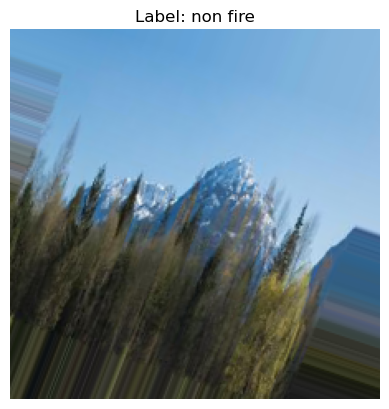

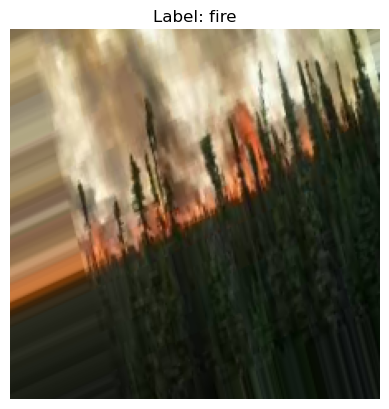

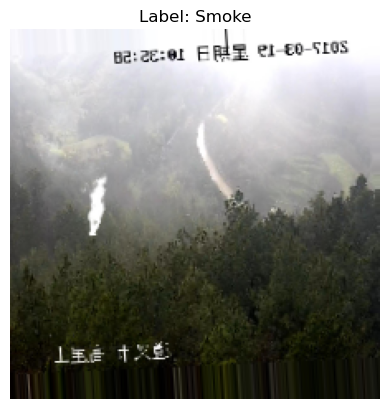

In [11]:

# Dictionary to track if we've already displayed an image for a class
displayed_classes = set()

# Class label mapping
class_indices = Train_Gen.class_indices
labels_map = {v: k for k, v in class_indices.items()}

# Iterate through the generator
for images, labels in Train_Gen:
    for i in range(len(labels)):
        label_index = np.argmax(labels[i])  # Get the class index
        label_name = labels_map[label_index]  # Convert index to class name
        
        # Check if this class has already been displayed
        if label_name not in displayed_classes:
            plt.imshow(images[i])
            plt.title(f"Label: {label_name}")
            plt.axis('off')
            plt.show()
            
            displayed_classes.add(label_name)
            
        # Break the loop if all classes have been displayed
        if len(displayed_classes) == len(class_indices):
            break
    if len(displayed_classes) == len(class_indices):
        break


### Displaying images from each class of Test dataset.

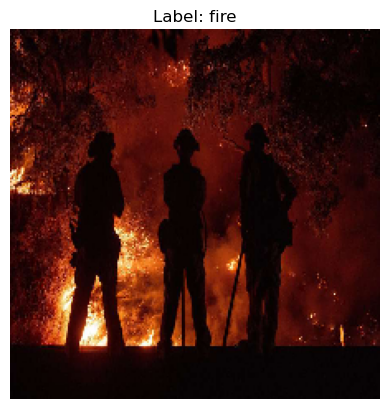

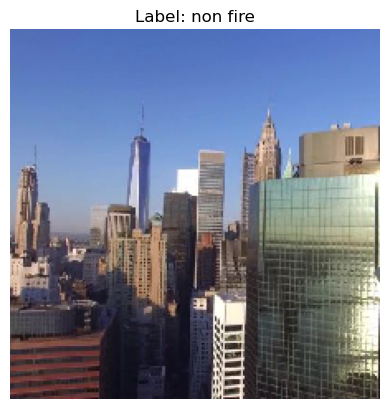

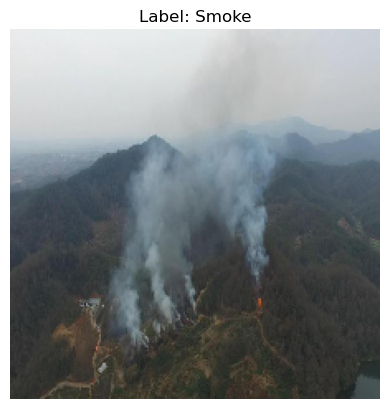

In [12]:

# Dictionary to track if we've already displayed an image for a class
displayed_classes = set()

# Class label mapping
class_indices = Test_Gen.class_indices
labels_map = {v: k for k, v in class_indices.items()}

# Iterate through the generator
for images, labels in Test_Gen:
    for i in range(len(labels)):
        label_index = np.argmax(labels[i])  # Get the class index
        label_name = labels_map[label_index]  # Convert index to class name
        
        # Check if this class has already been displayed
        if label_name not in displayed_classes:
            plt.imshow(images[i])
            plt.title(f"Label: {label_name}")
            plt.axis('off')
            plt.show()
            
            displayed_classes.add(label_name)
            
        # Break the loop if all classes have been displayed
        if len(displayed_classes) == len(class_indices):
            break
    if len(displayed_classes) == len(class_indices):
        break


# Checking the balance of our dataset

In [13]:
import os
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):  # Loop through class folders
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            num_images = len(os.listdir(class_dir))  # Count files in class folder
            class_counts[class_name] = num_images
    return class_counts

# Get counts for train and test sets
train_counts = count_images(train_path)
test_counts = count_images(test_path)

# Display counts
print("📊 Train Dataset:")
for class_name, count in train_counts.items():
    print(f"🔹 {class_name}: {count} images")

print("\n📊 Test Dataset:")
for class_name, count in test_counts.items():
    print(f"🔹 {class_name}: {count} images")

📊 Train Dataset:
🔹 fire: 10800 images
🔹 non fire: 10800 images
🔹 Smoke: 10800 images

📊 Test Dataset:
🔹 fire: 3500 images
🔹 non fire: 3500 images
🔹 Smoke: 3500 images


#### The result shows that the dataset is perfectly balanced.

# Building the Model for classification

### Model Initialization

In [14]:
Init_model= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),


    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 Classes: Fire, No-Fire, Smoke
    
])

C:\Users\shara\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Compile

In [15]:
Init_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics= ['accuracy'])

In [16]:
Init_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [21]:
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("fire_detection_model.keras", save_best_only=True)

In [22]:
history = Init_model.fit(
    Train_Gen,
    validation_data=Test_Gen,
    epochs=7, 
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/7
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 2405s 2s/step - accuracy: 0.9202 - loss: 0.2374 - val_accuracy: 0.8990 - val_loss: 0.3344
Epoch 2/7
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 2795s 3s/step - accuracy: 0.9332 - loss: 0.2073 - val_accuracy: 0.9040 - val_loss: 0.2802
Epoch 3/7
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 1581s 2s/step - accuracy: 0.9335 - loss: 0.2036 - val_accuracy: 0.9202 - val_loss: 0.2416
Epoch 4/7
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 1473s 1s/step - accuracy: 0.9383 - loss: 0.1898 - val_accuracy: 0.9268 - val_loss: 0.2028
Epoch 5/7
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 1565s 2s/step - accuracy: 0.9417 - loss: 0.1779 - val_accuracy: 0.9037 - val_loss: 0.2737
Epoch 6/7
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 1552s 2s/step - accuracy: 0.9431 - loss: 0.1760 - val_accuracy: 0.9169 - val_loss: 0.2722
Epoch 7/7
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 2437s 2s/step - accuracy: 0.9467 - loss: 0.1630 - val_accuracy: 0.9249 - val_loss: 0.2623


## Model Evalution.

In [23]:
test_loss, test_accuracy= Init_model.evaluate(Test_Gen)
print(f"Test Accuracy:{test_accuracy*100:.2f}%")

329/329 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.9287 - loss: 0.1976
Test Accuracy:92.55%


In [24]:
train_loss, train_accuracy= Init_model.evaluate(Train_Gen)
print(f"Train Accuracy:{train_accuracy*100:.2f}%")

1013/1013 ━━━━━━━━━━━━━━━━━━━━ 1564s 2s/step - accuracy: 0.9444 - loss: 0.1602
Train Accuracy:94.56%


### Vizualizing the performance of the model

#### Ploting the accuracy and loss.

Text(0.5, 1.0, 'Model Loss')

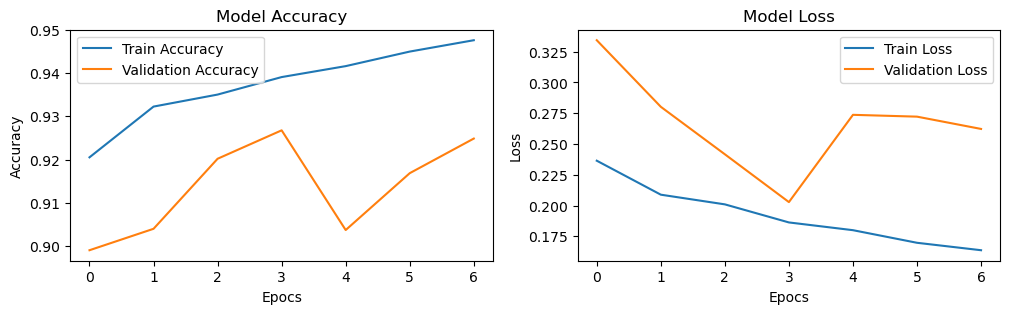

In [25]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epocs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

## Test with a new image.

In [26]:
# Creating a function to test the new image.
def fire_detect(img_path, model):
    img= image.load_img(img_path, target_size= ImageSize)
    img_array= image.img_to_array(img)
    img_array= np.expand_dims(img_array, axis=0)
    img_array=img_array/255
    prediction= model.predict(img_array)
    class_labels= list(Train_Gen.class_indices.keys())
    predicted_index = np.argmax(prediction)  # Get highest probability class index
    predicted_class = class_labels[predicted_index]  # Map index to class label
    confidence = prediction[0][predicted_index]  # Get confidence score

    #Display the images along with prediction.
    plt.figure(figsize=(6,4))
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {predicted_class} ({confidence:.2%} confidence)")
    plt.axis("off")
    plt.show()
    
    

# Testing the model with random new images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


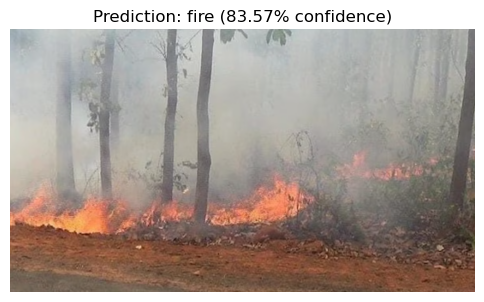

In [27]:
fire_detect(r"C:\Users\shara\Downloads\DataScience folder/1.png", Init_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


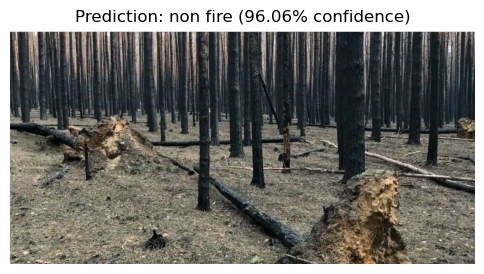

In [29]:
fire_detect(r"C:\Users\shara\Downloads\DataScience folder\2.png", Init_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


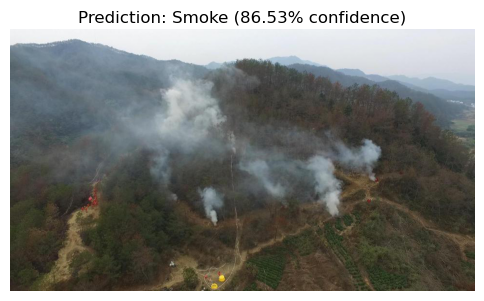

In [31]:
fire_detect(r"C:\Users\shara\Downloads\DataScience folder\6.jpg", Init_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


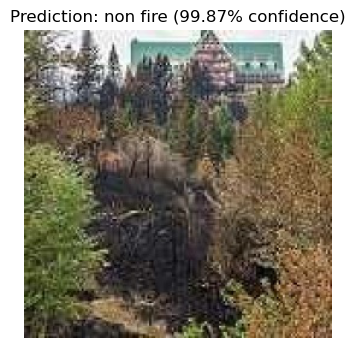

In [104]:
fire_detect(r"C:\Users\shara\Downloads\DataScience folder\10.jpg", Init_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


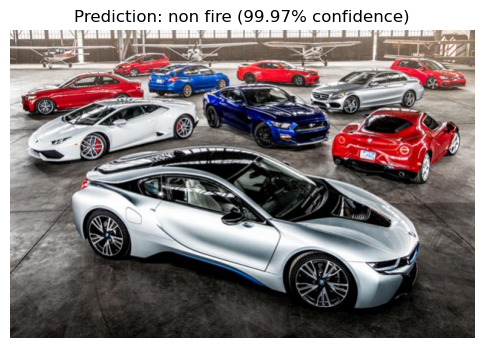

In [105]:
fire_detect(r"C:\Users\shara\Downloads\DataScience folder\11.png", Init_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


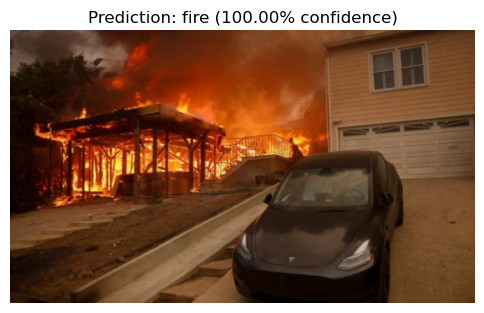

In [32]:
fire_detect(r"C:\Users\shara\Downloads\DataScience folder\12.png", Init_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


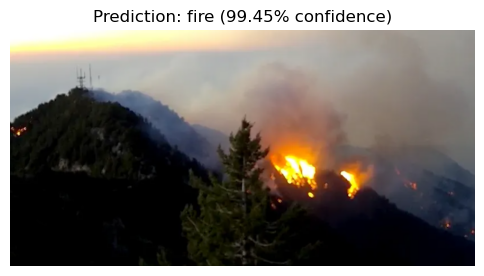

In [33]:
fire_detect(r"C:\Users\shara\Downloads\DataScience folder\13.png", Init_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


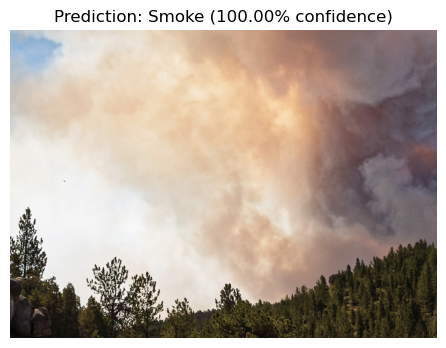

In [34]:
fire_detect(r"C:\Users\shara\Downloads\DataScience folder\14.png", Init_model)